In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
# !head -n 50 train01.csv

### Обработка данных

- Что делать с нанами?
    - pandas interpolate?
    - median?
    - Выкинуть фичи где > 50% nan
- длина 6 -- это наверное про месяцы
    - взять статистики по этой штуке
- длина не 6
    - средние статистики по сезонам/месяцам
    - разность средних по месяцам
- фичи из дат x2
    - больше года n
    - номер месяца
    - время года
    - выходной ли?

- пути улучшения
    - time series to vec
    - extract more features
    - попробовать всевозможные сабсеты фич (убрать лишние)
    - заменять выбросы средним

## Прочтем данные из файла

In [3]:
data = pd.read_csv("train01.csv", sep=";")
data2 = pd.read_csv("train02.csv", sep=";")
data_test = pd.read_csv("test.csv", sep=";")

In [4]:
data_joint = pd.concat([data,data2], ignore_index=True)

### Посмотрим что в данных

In [5]:
data.describe()

,id,y,x1,x3,x4,x5,x6,x7
count,9.194600e+04,91946.000000,9.194600e+04,9.194600e+04,91946.000000,7.878400e+04,9.194600e+04,91946.000000
mean,4.927884e+17,0.025178,-2.447440e+18,6.273081e+18,161.080384,-1.118405e+18,-1.341169e+18,1.260707
std,5.286931e+18,0.156666,1.681012e+18,5.634447e+17,40.903555,6.406295e+18,5.356071e+18,1.732071
min,-9.196903e+18,0.000000,-8.986902e+18,-6.781590e+18,0.000000,-8.552464e+18,-9.204708e+18,0.000000
25%,-4.124670e+18,0.000000,-2.754919e+18,6.312572e+18,163.000000,-6.347413e+18,-6.335165e+18,0.000000
50%,8.753468e+17,0.000000,-2.201458e+18,6.312572e+18,181.000000,-5.150561e+18,-2.297459e+18,1.000000
75%,5.044115e+18,0.000000,-2.201458e+18,6.312572e+18,182.000000,6.439227e+18,2.830195e+18,2.000000
max,9.162041e+18,1.000000,7.609240e+18,8.072835e+18,182.000000,8.878400e+18,9.202926e+18,15.000000


In [6]:
data.dtypes

id       int64
y        int64
x1       int64
x2      object
x3       int64
x4       int64
x5     float64
x6       int64
x7       int64
x8      object
x9      object
x10     object
x11     object
x12     object
x13     object
x14     object
x15     object
x16     object
x17     object
x18     object
x19     object
x20     object
x21     object
x22     object
x23     object
x24     object
x25     object
x26     object
x27     object
x28     object
x29     object
x30     object
x31     object
x32     object
x33     object
x34     object
x35     object
x36     object
x37     object
x38     object
x39     object
x40     object
x41     object
x42     object
dtype: object

In [7]:
for col in list(data.columns)[9:]:
    series = list(data[col])
    fst = series[0]
    print(f"Col name: {col}, len: {len(fst)}, starting: {fst[:40]}")

Col name: x8, len: 3111, starting: [4770.1499999999996 885.49000000000001 1
Col name: x9, len: 6074, starting: [4770.1499999999996 885.49000000000001 1
Col name: x10, len: 30, starting: [nan, nan, nan, nan, nan, nan]
Col name: x11, len: 30, starting: [nan, nan, nan, nan, nan, nan]
Col name: x12, len: 30, starting: [nan, nan, nan, nan, nan, nan]
Col name: x13, len: 30, starting: [nan, 1.0, nan, nan, 1.0, 1.0]
Col name: x14, len: 30, starting: [nan, 0.0, nan, nan, 0.0, 0.0]
Col name: x15, len: 30, starting: [nan, 1.0, nan, nan, 0.0, 0.0]
Col name: x16, len: 30, starting: [nan, 0.0, nan, nan, 0.0, 0.0]
Col name: x17, len: 30, starting: [nan, 1.0, nan, nan, 0.0, 0.0]
Col name: x18, len: 35, starting: [nan, 0.94, nan, nan, 47.67, 141.2]
Col name: x19, len: 34, starting: [nan, 0.02, nan, nan, 47.67, 70.6]
Col name: x20, len: 35, starting: [nan, 0.28, nan, nan, 0.0, 9969.07]
Col name: x21, len: 30, starting: [nan, 0.0, nan, nan, 0.0, 0.0]
Col name: x22, len: 30, starting: [nan, 0.0, nan, nan,

In [8]:
import ast, json

In [9]:
def prepare_x8_x9(series_str):
    split = series_str.split()
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
#     return [float(x) for x in split if x != "nan" and x != "na"]
    return [float(x) if x != "nan" and x != "na" else "nan" for x in split]

def prepare_x10p(series_str):
    split = series_str.split(", ")
    split[0] = split[0][1:]
    split[-1] = split[-1][:-1]
    return [float(x) if x != "nan" and x != "na" else "nan" for x in split]

In [10]:
prepare_x10p(data["x10"][0])

['nan', 'nan', 'nan', 'nan', 'nan', 'nan']

In [11]:
def check_x8_x9_correlation(data):
    num_x8_eq_x9 = 0
    lens_x8 = []
    lens_x9 = []
    for row_i in range(len(data.index)):
        x8 = prepare_x8_x9(data["x8"][row_i])
        x9 = prepare_x8_x9(data["x9"][row_i])
        x8.sort()
        x9.sort()
        lens_x8.append(len(x8))
        lens_x9.append(len(x9))
        if x8 == x9:
            num_x8_eq_x9 += 1
    print(f"Num equal rows: {num_x8_eq_x9}, proportion: {num_x8_eq_x9 / len(data.index)}.")
    print(f"Max x8 len: {max(lens_x8)}. Min x8 len: {min(lens_x8)}")
    print(f"Max x9 len: {max(lens_x9)}. Min x9 len: {min(lens_x9)}")

In [12]:
check_x8_x9_correlation(data)

TypeError: '<' not supported between instances of 'str' and 'float'

In [ ]:
# check_x8_x9_correlation(data2)

In [13]:
def get_stats_on_time_series_columns(data, nan_tresh=0.7):
    columns = list(data.columns)[9:]
    nan_proportion_mean_per_row = [0] * len(columns)
    len_row_min = [1000000] * len(columns)
    len_row_max = [0] * len(columns)
    print(columns)
    for i in tqdm(range(len(data.index))):
        for col_i, col in enumerate(columns):
            colser = prepare_x10p(data[col][i]) if col not in ["x8", "x9"] else prepare_x8_x9(data[col][i])
            colser_nans = sum([1 if x == "nan" else 0 for x in colser])
            colser_len = len(colser)
            len_row_min[col_i] = min(len_row_min[col_i], colser_len)
            len_row_max[col_i] = max(len_row_max[col_i], colser_len)
            nan_proportion_mean_per_row[col_i] += (colser_nans / colser_len)
    for i in range(len(nan_proportion_mean_per_row)):
        nan_proportion_mean_per_row[i] /= len(data.index)
        
    print("Printing stats:")
    columns_filtered = []
    for i, col in enumerate(columns):
        if (nan_proportion_mean_per_row[i] < nan_tresh):
            columns_filtered.append(col)
        print(f"Col: {col}, nan_prop_per_row: {nan_proportion_mean_per_row[i]}, \
        len_row_min: {len_row_min[i]}, len_row_max: {len_row_max[i]}")
    return columns_filtered

In [14]:
data["x10"][0]

'[nan, nan, nan, nan, nan, nan]'

In [15]:
columns_filtered_nan_tresh = get_stats_on_time_series_columns(data)

['x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42']


  0%|          | 0/91946 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
data["x2"].head()

Таким образом, первые 7 признаков -- численные и временные; а остальные -- временные ряды.

## Обработаем данные и получим датасет

In [118]:
def deal_with_nans(ds):
    ds.interpolate(method='linear', inplace=True)
    return ds

def remove_non_numeric(data):
    data_joint_numeric = data.select_dtypes(['number'])
    X = data_joint_numeric.drop(columns="y")
    y = data_joint_numeric["y"]
    return X, y

# Month
def get_date_feature_1(date):
    if not isinstance(date, str):
        return "nan"
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            return int(date.split("-")[1])
        else:
            return "nan"
    return int(date.split(".")[1])

# Season
def get_date_feature_6(date):
    if not isinstance(date, str):
        return "nan"
    seasons = [month%12 // 3 + 1 for month in range(1, 13)]
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            m = int(date.split("-")[1])
            return seasons[m-1]
        else:
            return "nan"
    m = int(date.split(".")[1])
    return seasons[m-1]

# Year
def get_date_feature_2(date):
    if not isinstance(date, str):
        return "nan"
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            year = int(date.split("-")[0])
        else:
            return "nan"
    else:
        year = int(date.split(".")[2])
    return year

# Year greater 2010
def get_date_feature_3(date):
    if not isinstance(date, str):
        return "nan"
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            year = int(date.split("-")[0])
        else:
            return "nan"
    else:
        year = int(date.split(".")[2])
    return bool(year > 2010)

# Year greater 2015
def get_date_feature_4(date):
    if not isinstance(date, str):
        return "nan"
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            year = int(date.split("-")[0])
        else:
            return "nan"
    else:
        year = int(date.split(".")[2])
    return bool(year > 2015)

# Year greater 2005
def get_date_feature_5(date):
    if not isinstance(date, str):
        return "nan"
    if "-" in date:
        if int(date.split("-")[0]) > 1000:
            year = int(date.split("-")[0])
        else:
            return "nan"
    else:
        year = int(date.split(".")[2])
    return bool(year > 2005)

# Is weekend
def get_date_feature_7(date):
    #todo
    pass

def get_date_features(date):
    return [get_date_feature_1(date), get_date_feature_2(date), get_date_feature_3(date), \
           get_date_feature_4(date), get_date_feature_5(date), get_date_feature_6(date)]


def add_date_features(data):
    N_DATE_FEATURES= 6
    data_new = data.copy()
    
    f_x2_new = data["x2"].apply(lambda x: get_date_features(x))
    
    data_new = data_new.assign(x2_new=f_x2_new.values)
    
    data_new[[f"x2_new_{i}" for i in range(N_DATE_FEATURES)]] = pd.DataFrame(data_new.x2_new.tolist(), index= data_new.index)
    data_new.drop('x2_new', axis=1, inplace=True)
    data_new.drop('x2', axis=1, inplace=True)
    return data_new


def get_daily_features_x8(x8_series):
    x8_series = interpolate_series(prepare_x8_x9(x8_series))
    x8_series = [x for x in x8_series if x != "nan"]
    features = []
    s_change = 45
    for i in range(4):
        features.append(np.mean(x8_series[(i*s_change):((i+1)*s_change)]))
        features.append(np.max(x8_series[(i*s_change):((i+1)*s_change)], initial=10000000))
        features.append(np.min(x8_series[(i*s_change):((i+1)*s_change)], initial=-10000000))
    features_copy = features.copy()
    features_copy.insert(0, features_copy[-1])
    features_copy = features_copy[:-1]
    features += list(np.array(features_copy) - np.array(features))
    return features


def get_daily_features_x9(x9_series):
    x9_series = interpolate_series(prepare_x8_x9(x9_series))
    x9_series = [x for x in x9_series if x != "nan"]
    features = []
    s_change = 91
    for i in range(4):
        features.append(np.mean(x9_series[(i*s_change):((i+1)*s_change)]))
        features.append(np.max(x9_series[(i*s_change):((i+1)*s_change)], initial=10000000))
        features.append(np.min(x9_series[(i*s_change):((i+1)*s_change)], initial=-10000000))
    features_copy = features.copy()
    features_copy.insert(0, features_copy[-1])
    features_copy = features_copy[:-1]
    features += list(np.array(features_copy) - np.array(features))
    return features

def add_daily_features_x8(data):
    N_DATE_FEATURES= 0
    data_new = data.copy()
    
    f_x8_new = data["x8"].apply(lambda x: get_daily_features_x8(x))
    N_DATE_FEATURES = len(get_daily_features_x9(data["x8"][0]))
    
    data_new = data_new.assign(x8_new=f_x8_new.values)
    
    data_new[[f"x8_new_{i}" for i in range(N_DATE_FEATURES)]] = pd.DataFrame(data_new.x8_new.tolist(), index= data_new.index)
    data_new.drop('x8_new', axis=1, inplace=True)
    data_new.drop('x8', axis=1, inplace=True)
    return data_new

def add_daily_features_x9(data):
    N_DATE_FEATURES= 0
    data_new = data.copy()
    
    f_x9_new = data["x9"].apply(lambda x: get_daily_features_x9(x))
    N_DATE_FEATURES = len(get_daily_features_x9(data["x9"][0]))
    
    data_new = data_new.assign(x9_new=f_x9_new.values)
    
    data_new[[f"x9_new_{i}" for i in range(N_DATE_FEATURES)]] = pd.DataFrame(data_new.x9_new.tolist(), index= data_new.index)
    data_new.drop('x9_new', axis=1, inplace=True)
    data_new.drop('x9', axis=1, inplace=True)
    return data_new

def add_daily_features(data):
    data = add_daily_features_x8(data)
    data = add_daily_features_x9(data)
    return data

def get_m_features(xm_series):
#     xm_series = 
    xm_series = interpolate_series(prepare_x10p(xm_series))
    xm_series = [x for x in xm_series if x != "nan"]
    features = [np.mean(xm_series), np.max(xm_series, initial=1000000), np.min(xm_series, initial=-1000000)]
    return features

def add_month_features(data, cols):
    data_new = data.copy()
    for col in tqdm(cols):
        N_M_FEATURES= 0
        data_new = data_new.copy()

        f_m_new = data[col].apply(lambda x: get_m_features(x))
        N_M_FEATURES = len(get_m_features(data[col][0]))

        data_new = data_new.assign(xm_new=f_m_new.values)

        data_new[[f"xm_new_{col}_{i}" for i in range(N_M_FEATURES)]] = pd.DataFrame(data_new.xm_new.tolist(), index= data_new.index)
        data_new.drop('xm_new', axis=1, inplace=True)
        data_new.drop(col, axis=1, inplace=True)
    return data_new

def add_features_from_time_series(data, feature_set=None, assert_cols=None):
    initial_columns = data.columns
    print(initial_columns)
    if not feature_set:
        columns_filtered_nan_tresh = get_stats_on_time_series_columns(data)
        feature_set = columns_filtered_nan_tresh
    data = add_date_features(data)
    print("done date features")
    for c in initial_columns[10:]:
        print(f"Checking feature {c}")
        if c not in feature_set:
            data = data.drop(c, axis=1, inplace=False)
    data = add_month_features(data, feature_set[2:])
    print("done month features")
    data = add_daily_features(data)
    print("done daily features")
#     if assert_cols is not None:
#         print(f"Cols are the same: {data.columns == assert_cols}")
    return data, feature_set

def interpolate_series(series):
    series = [x if x != "nan" else np.NaN for x in series]
    return pd.Series(series).interpolate().to_list()

def process_data(data, feature_set=None, assert_cols=None):
    data = deal_with_nans(data)
    data = add_features_from_time_series(data, feature_set, assert_cols)
    return data

In [46]:
processed_data = process_data(data)

done date features
['x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x2_new_0', 'x2_new_1', 'x2_new_2', 'x2_new_3', 'x2_new_4', 'x2_new_5']


  0%|          | 0/91946 [00:00<?, ?it/s]

AttributeError: 'int' object has no attribute 'split'

In [70]:
data_joint_processed, data_joint_processed_features = process_data(data_joint)
data_joint_processed.to_csv("data_joint_processed.csv")

Index(['id', 'y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42'],
      dtype='object')
['x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42']


  0%|          | 0/185135 [00:00<?, ?it/s]

Printing stats:
Col: x8, nan_prop_per_row: 0.0882449705384601,         len_row_min: 182, len_row_max: 184
Col: x9, nan_prop_per_row: 0.14125468252130677,         len_row_min: 364, len_row_max: 368
Col: x10, nan_prop_per_row: 0.9863360970823855,         len_row_min: 6, len_row_max: 6
Col: x11, nan_prop_per_row: 0.8333765450437008,         len_row_min: 6, len_row_max: 6
Col: x12, nan_prop_per_row: 0.7340076160638711,         len_row_min: 6, len_row_max: 6
Col: x13, nan_prop_per_row: 0.533945499230297,         len_row_min: 6, len_row_max: 6
Col: x14, nan_prop_per_row: 0.533945499230297,         len_row_min: 6, len_row_max: 6
Col: x15, nan_prop_per_row: 0.533945499230297,         len_row_min: 6, len_row_max: 6
Col: x16, nan_prop_per_row: 0.533945499230297,         len_row_min: 6, len_row_max: 6
Col: x17, nan_prop_per_row: 0.533945499230297,         len_row_min: 6, len_row_max: 6
Col: x18, nan_prop_per_row: 0.5391822183811862,         len_row_min: 6, len_row_max: 6
Col: x19, nan_prop_per_ro

  0%|          | 0/16 [00:00<?, ?it/s]

done month features


/usr/local/Caskroom/miniconda/base/envs/hse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniconda/base/envs/hse/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done daily features


In [26]:
data_joint.to_csv("data_joint.csv")

In [93]:
X = data_joint_processed.drop(columns="y")
y = data_joint["y"]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [95]:
catboost_pool = Pool(X_train, y_train)
catboost_pool_val = Pool(X_val, y_val)
catboost_pool_test = Pool(X_test, y_test)

## Модель

- CatBoost
- RandomForest

In [96]:
model = CatBoostClassifier(learning_rate=0.03)

In [97]:
model.fit(X_train, y_train)

0:	learn: 0.6340743	total: 30.3ms	remaining: 30.3s
1:	learn: 0.5876931	total: 51.4ms	remaining: 25.7s
2:	learn: 0.5412562	total: 69.6ms	remaining: 23.1s
3:	learn: 0.5002140	total: 82.1ms	remaining: 20.5s
4:	learn: 0.4613037	total: 101ms	remaining: 20.1s
5:	learn: 0.4277060	total: 133ms	remaining: 22.1s
6:	learn: 0.3973273	total: 156ms	remaining: 22.1s
7:	learn: 0.3723880	total: 176ms	remaining: 21.8s
8:	learn: 0.3499391	total: 190ms	remaining: 20.9s
9:	learn: 0.3294161	total: 208ms	remaining: 20.6s
10:	learn: 0.3086339	total: 225ms	remaining: 20.3s
11:	learn: 0.2884517	total: 247ms	remaining: 20.3s
12:	learn: 0.2705509	total: 269ms	remaining: 20.4s
13:	learn: 0.2571044	total: 290ms	remaining: 20.4s
14:	learn: 0.2400344	total: 327ms	remaining: 21.5s
15:	learn: 0.2256765	total: 353ms	remaining: 21.7s
16:	learn: 0.2150896	total: 374ms	remaining: 21.6s
17:	learn: 0.2026734	total: 392ms	remaining: 21.4s
18:	learn: 0.1928926	total: 411ms	remaining: 21.2s
19:	learn: 0.1826970	total: 430ms	rem

169:	learn: 0.0765073	total: 3.62s	remaining: 17.7s
170:	learn: 0.0764941	total: 3.64s	remaining: 17.7s
171:	learn: 0.0764777	total: 3.66s	remaining: 17.6s
172:	learn: 0.0764396	total: 3.68s	remaining: 17.6s
173:	learn: 0.0764269	total: 3.7s	remaining: 17.6s
174:	learn: 0.0763806	total: 3.72s	remaining: 17.5s
175:	learn: 0.0763558	total: 3.74s	remaining: 17.5s
176:	learn: 0.0763265	total: 3.76s	remaining: 17.5s
177:	learn: 0.0763007	total: 3.78s	remaining: 17.5s
178:	learn: 0.0762852	total: 3.8s	remaining: 17.4s
179:	learn: 0.0762717	total: 3.81s	remaining: 17.4s
180:	learn: 0.0762554	total: 3.84s	remaining: 17.4s
181:	learn: 0.0762348	total: 3.86s	remaining: 17.3s
182:	learn: 0.0762233	total: 3.88s	remaining: 17.3s
183:	learn: 0.0762098	total: 3.9s	remaining: 17.3s
184:	learn: 0.0761834	total: 3.92s	remaining: 17.3s
185:	learn: 0.0761418	total: 3.94s	remaining: 17.2s
186:	learn: 0.0760993	total: 3.96s	remaining: 17.2s
187:	learn: 0.0760755	total: 3.98s	remaining: 17.2s
188:	learn: 0.0

334:	learn: 0.0736394	total: 7.03s	remaining: 14s
335:	learn: 0.0736279	total: 7.07s	remaining: 14s
336:	learn: 0.0736094	total: 7.1s	remaining: 14s
337:	learn: 0.0735871	total: 7.14s	remaining: 14s
338:	learn: 0.0735715	total: 7.16s	remaining: 14s
339:	learn: 0.0735559	total: 7.18s	remaining: 13.9s
340:	learn: 0.0735487	total: 7.2s	remaining: 13.9s
341:	learn: 0.0735403	total: 7.22s	remaining: 13.9s
342:	learn: 0.0735310	total: 7.25s	remaining: 13.9s
343:	learn: 0.0735081	total: 7.27s	remaining: 13.9s
344:	learn: 0.0735028	total: 7.28s	remaining: 13.8s
345:	learn: 0.0734896	total: 7.3s	remaining: 13.8s
346:	learn: 0.0734742	total: 7.32s	remaining: 13.8s
347:	learn: 0.0734570	total: 7.34s	remaining: 13.8s
348:	learn: 0.0734444	total: 7.36s	remaining: 13.7s
349:	learn: 0.0734358	total: 7.38s	remaining: 13.7s
350:	learn: 0.0734075	total: 7.39s	remaining: 13.7s
351:	learn: 0.0734018	total: 7.41s	remaining: 13.6s
352:	learn: 0.0733797	total: 7.43s	remaining: 13.6s
353:	learn: 0.0733681	tot

494:	learn: 0.0714184	total: 10.2s	remaining: 10.4s
495:	learn: 0.0714104	total: 10.2s	remaining: 10.4s
496:	learn: 0.0714009	total: 10.3s	remaining: 10.4s
497:	learn: 0.0713858	total: 10.3s	remaining: 10.4s
498:	learn: 0.0713764	total: 10.3s	remaining: 10.3s
499:	learn: 0.0713617	total: 10.3s	remaining: 10.3s
500:	learn: 0.0713408	total: 10.3s	remaining: 10.3s
501:	learn: 0.0713217	total: 10.4s	remaining: 10.3s
502:	learn: 0.0713090	total: 10.4s	remaining: 10.2s
503:	learn: 0.0712986	total: 10.4s	remaining: 10.2s
504:	learn: 0.0712909	total: 10.4s	remaining: 10.2s
505:	learn: 0.0712773	total: 10.4s	remaining: 10.2s
506:	learn: 0.0712665	total: 10.5s	remaining: 10.2s
507:	learn: 0.0712475	total: 10.5s	remaining: 10.1s
508:	learn: 0.0712368	total: 10.5s	remaining: 10.1s
509:	learn: 0.0712226	total: 10.5s	remaining: 10.1s
510:	learn: 0.0712124	total: 10.5s	remaining: 10.1s
511:	learn: 0.0711920	total: 10.6s	remaining: 10.1s
512:	learn: 0.0711856	total: 10.6s	remaining: 10s
513:	learn: 0.

662:	learn: 0.0693111	total: 13.7s	remaining: 6.97s
663:	learn: 0.0693059	total: 13.7s	remaining: 6.95s
664:	learn: 0.0692990	total: 13.8s	remaining: 6.93s
665:	learn: 0.0692924	total: 13.8s	remaining: 6.9s
666:	learn: 0.0692836	total: 13.8s	remaining: 6.88s
667:	learn: 0.0692773	total: 13.8s	remaining: 6.86s
668:	learn: 0.0692626	total: 13.8s	remaining: 6.84s
669:	learn: 0.0692580	total: 13.8s	remaining: 6.82s
670:	learn: 0.0692473	total: 13.9s	remaining: 6.79s
671:	learn: 0.0692323	total: 13.9s	remaining: 6.77s
672:	learn: 0.0692132	total: 13.9s	remaining: 6.75s
673:	learn: 0.0691949	total: 13.9s	remaining: 6.73s
674:	learn: 0.0691861	total: 13.9s	remaining: 6.71s
675:	learn: 0.0691743	total: 14s	remaining: 6.69s
676:	learn: 0.0691563	total: 14s	remaining: 6.67s
677:	learn: 0.0691438	total: 14s	remaining: 6.65s
678:	learn: 0.0691294	total: 14s	remaining: 6.63s
679:	learn: 0.0691146	total: 14s	remaining: 6.61s
680:	learn: 0.0691041	total: 14.1s	remaining: 6.59s
681:	learn: 0.0690827	t

829:	learn: 0.0673381	total: 17.2s	remaining: 3.52s
830:	learn: 0.0673109	total: 17.2s	remaining: 3.5s
831:	learn: 0.0672854	total: 17.2s	remaining: 3.48s
832:	learn: 0.0672752	total: 17.2s	remaining: 3.46s
833:	learn: 0.0672532	total: 17.3s	remaining: 3.44s
834:	learn: 0.0672486	total: 17.3s	remaining: 3.42s
835:	learn: 0.0672395	total: 17.3s	remaining: 3.39s
836:	learn: 0.0672292	total: 17.3s	remaining: 3.37s
837:	learn: 0.0672129	total: 17.3s	remaining: 3.35s
838:	learn: 0.0672000	total: 17.4s	remaining: 3.33s
839:	learn: 0.0671808	total: 17.4s	remaining: 3.31s
840:	learn: 0.0671749	total: 17.4s	remaining: 3.29s
841:	learn: 0.0671709	total: 17.4s	remaining: 3.27s
842:	learn: 0.0671462	total: 17.5s	remaining: 3.25s
843:	learn: 0.0671335	total: 17.5s	remaining: 3.23s
844:	learn: 0.0671243	total: 17.5s	remaining: 3.21s
845:	learn: 0.0671139	total: 17.5s	remaining: 3.19s
846:	learn: 0.0671003	total: 17.5s	remaining: 3.17s
847:	learn: 0.0670921	total: 17.5s	remaining: 3.15s
848:	learn: 0

996:	learn: 0.0653915	total: 20.6s	remaining: 62.1ms
997:	learn: 0.0653816	total: 20.6s	remaining: 41.4ms
998:	learn: 0.0653644	total: 20.7s	remaining: 20.7ms
999:	learn: 0.0653501	total: 20.7s	remaining: 0us


## Train AUC/ROC

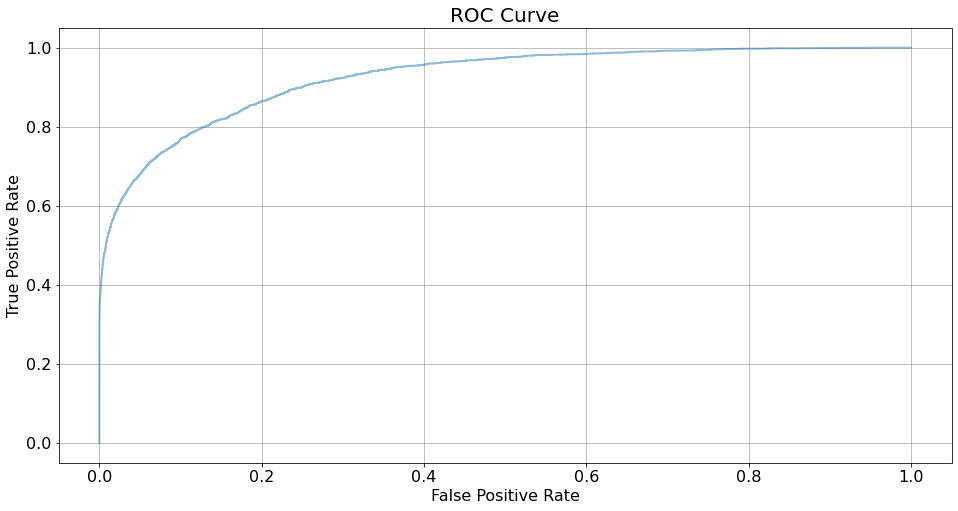

In [98]:
(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool, plot=True)

In [99]:
roc_auc_score(y_train, model.predict(X_train))

0.6442389815321846

## Val AUC/ROC

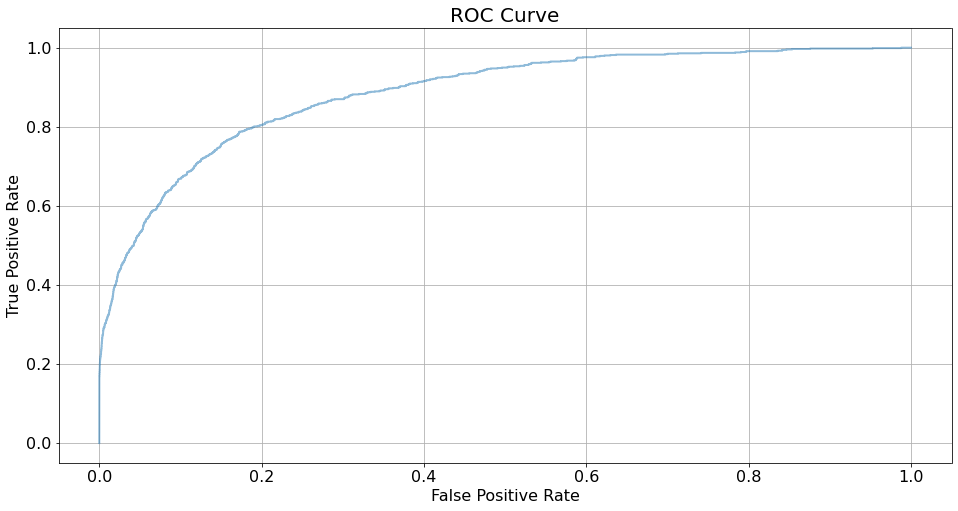

In [104]:
(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool_val, plot=True)

In [105]:
roc_auc_score(y_val, model.predict(X_val))

0.6013905658757362

## Test AUC/ROC

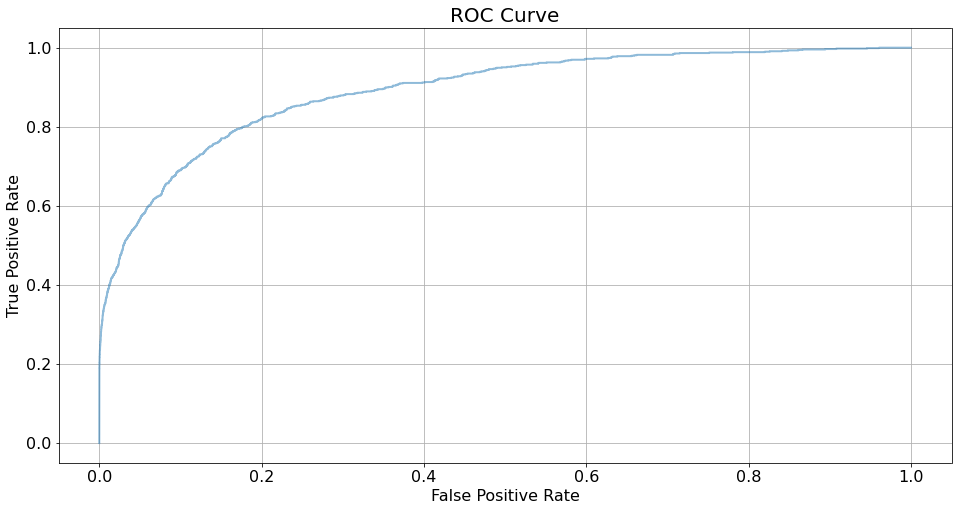

In [106]:
(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool_test, plot=True)

In [107]:
roc_auc_score(y_test, model.predict(X_test))

0.6165127922908913

# get vals for test data

In [114]:
train_columns = data_joint_processed.columns

In [119]:
data_test_processed, _ = process_data(data_test, data_joint_processed_features, train_columns)

Index(['id', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10',
       'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20',
       'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30',
       'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40',
       'x41', 'x42'],
      dtype='object')
done date features
Checking feature x10
Checking feature x11
Checking feature x12
Checking feature x13
Checking feature x14
Checking feature x15
Checking feature x16
Checking feature x17
Checking feature x18
Checking feature x19
Checking feature x20
Checking feature x21
Checking feature x22
Checking feature x23
Checking feature x24
Checking feature x25
Checking feature x26
Checking feature x27
Checking feature x28
Checking feature x29
Checking feature x30
Checking feature x31
Checking feature x32
Checking feature x33
Checking feature x34
Checking feature x35
Checking feature x36
Checking feature x37
Checking feature x38
Checking feature x39
Ch

  0%|          | 0/16 [00:00<?, ?it/s]

done month features


/usr/local/Caskroom/miniconda/base/envs/hse/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniconda/base/envs/hse/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


done daily features


In [129]:
data_test_processed_preds = model.predict_proba(data_test_processed)

In [155]:
with open('answer.csv', 'w') as f:
    f.write(f"Id;result\n")
    for i, x in tqdm(enumerate(data_test_processed["id"])):
        f.write(f"{x};{data_test_processed_preds[i][1]}\n")    

0it [00:00, ?it/s]

In [156]:
!head answer.csv

Id;result
-9196902500682081904;0.008074452922784291
-9196902500681081889;0.011005824461754127
-9196902500679081891;0.0024762765324512783
-9196902500679081889;0.010951417180619786
-9196902500677081902;0.0007115527249936708
-9196902500676081905;0.0007576486052360729
-9196902500675081917;0.0010080042037247886
-9196902500673081913;0.001016941340832234
-9196902500673081912;0.0633586264738988
